# Electrode surface charge transfer modeled by Butler Volmer kinetics 

This model is commonly called the Single Particle Model (SPM).

The potential of the cell is determined by the cathode and anode open circuit potential and their Lithium concentration, $c_i$, and each electrodes overpotential $\eta_i$.

$$
U = U_p(c_p) - U_n(c_n) + \eta_p + \eta_n
$$

Where $p$ is the positive electrode, and $n$ the negative electrode.\
\
The electrode overpotential $\eta_i$ is described by the Butler-Volmer equation:

$$
i_i = i_{i, 0} \cdot \left[ e^{\frac{\alpha_a n F}{RT}\eta_i} - e^{-\frac{\alpha_c n F}{RT}\eta_i}\right]
$$

Where $i_i$ is the electrode current density, $i_{i, 0}$ is the electrode's exchange current density, $n$ is the number of electrons, $F$ is the Faraday constant, $R$ is the ideal gas constant, $T$ is the temperature and $\eta_i$ is the electrode overpotential. Lastly we have $\alpha_a$ and $\alpha_c$ which is the anodic and cathodic charge transfer coefficients for the given electrode. For $Li^+$ intercalation, the anodic and cathodic reaction is simply the reverse and forward direction of $Li^+ + e^- \leftrightarrow Li$ respectively. Usually these charge transfer coefficients are set to be 0.5, and we do the same to be able to simplify the expression using $2\sinh(x) = e^x -e^{-x}$ as follows:

$$
i_i = i_{i, 0} \cdot 2 \sinh \left(\frac{n F}{2RT}\eta_i\right)
$$

Rearranging in terms of the overpotential gives:

$$
\eta_i = \frac{2RT}{n F} \text{arcsinh} \left( \frac{i_i}{2 i_{i, 0}} \right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dataclasses import dataclass


In [2]:

@dataclass
class ParameterSet:
    """Parameters of model 02"""
    # Max lithium concentrations in electrodes
    c_max_n: float = 34684 # mol/m³
    c_max_p: float = 50060 # mol/m³
    # Initial parameters
    c_init_n: float = 1000 # mol/m³
    c_init_p: float = 49000 # mol/m³

    # Radiuses was calculated from c_max and theoretical capacity of 3.2Ah by r = cbrt(3/(4*pi) * 3.2Ah/(F*C_max))
    r_n: float = 0.02009/2 # m
    r_p: float = 0.01778/2 # m

    # Constants
    n: float = 1 # Unitless, number of charges in a reaction. Li+ + e- -> Li has 1.
    F: float = 96485.3321233100184 # C/mol (=As/mol), SI
    R: float = 8.31446261815324 # J/(K*mol), SI
    T: float = 298.15 # Kelvin, equaling 25 degrees

    # Kinetic parameters
    i0_n: float = 0.1 # anode exchange current density Chen2020 gives 0.1-0.3A/m²
    i0_p: float = 0.1 # cathode exchange current density

    # Open circuit potential of lithium concentration
    def U_n(self, c):
        x = c/self.c_max_n # Converting to stoichiometry
        p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
        return (
                p[0] * np.exp(-p[1] * x)
                + p[2]
                - p[3] * np.tanh(p[4] * (x - p[5]))
                - p[6] * np.tanh(p[7] * (x - p[8]))
                - p[9] * np.tanh(p[10] * (x - p[11]))
            )
    
    def U_p(self, c):
        x = c/self.c_max_p # Converting to stoichiometry
        p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])
        return (
                -p[0] * x
                + p[1]
                - p[2] * np.tanh(p[3] * (x - p[4]))
                - p[5] * np.tanh(p[6] * (x - p[7]))
                + p[8] * np.tanh(p[9] * (x - p[10]))
            )


@dataclass
class CurrentFunction:
    tp: np.ndarray # time array, monotonically increasing
    ip: np.ndarray # current array
    def __init__(self, t, i):
        self.tp = t
        self.ip = i

    def I(self, t):
        return np.interp(t, self.tp, self.ip)


class Model():
    def __init__(self, parameters: ParameterSet, current_function: CurrentFunction):
        self.p = parameters
        self.cf = current_function

    def U_batt(self, c_p_sol, c_n_sol, eta_p, eta_n):
        return self.p.U_p(c_p_sol.y[0]) - self.p.U_n(c_n_sol.y[0]) + eta_p + eta_n

    def eta(self, i, i0):
        """
        Butler volmer overpotential assuming symmetry
        i is current density
        i0 is exchange current density
        returns BV overpotential
        """
        eta = (2*self.p.R*self.p.T)/(self.p.n * self.p.F) * np.arcsinh(i/(2*i0))
        return eta

    def V(self, r):
        """Volume of a sphere given the radius"""
        return 4/3 * np.pi * r**3

    def dcdt(self, t, y, i, r):
        """
        t: Time
        y: state
        i: Electrode negative, n or positive p
        r: Radius of electrode particle
        n: Number of electrons in process
        F: Faraday constant in Coulomb/mol (=As/mol)
        """
        c_init = y

        if i == 'p':
            a = -1
        elif i == 'n':
            a = 1
        else:
            raise ValueError
        
        return a * self.cf.I(t) / (self.p.n * self.p.F * self.V(r))
    
    def solve(self, t_eval = None):
        if type(t_eval) == type(None):
            t_eval = np.linspace(np.min(self.cf.tp), np.max(self.cf.tp), 10000)
        # t_eval = np.linspace(0, 6*3600, 10000)
        t_span = [min(t_eval), max(t_eval)]

        n_y0 = [self.p.c_init_n]
        n_args = ('n', self.p.r_n)
        c_n_sol = solve_ivp(self.dcdt, t_span, n_y0, t_eval=t_eval, args = n_args)

        p_y0 = [self.p.c_init_p]
        p_args = ('p', self.p.r_p)
        c_p_sol = solve_ivp(self.dcdt, t_span, p_y0, t_eval=t_eval, args = p_args)

        eta_p = self.eta(self.cf.I(t_eval), self.p.i0_p)
        eta_n = self.eta(self.cf.I(t_eval), self.p.i0_n)

        U = self.U_batt(c_p_sol, c_n_sol, eta_p, eta_n)
        return t_eval, U

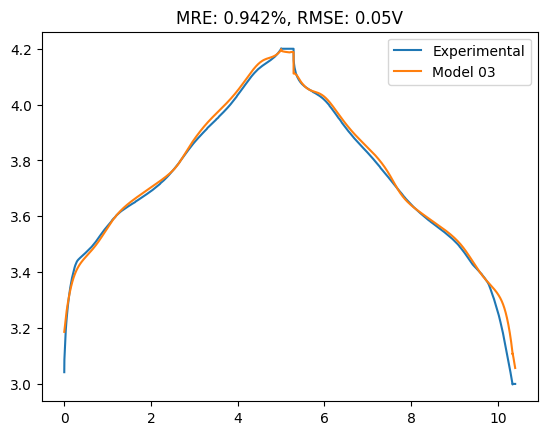

In [14]:
# Comparing model to reference cell at BoL
exp = np.genfromtxt('MJ1_01_01_C5.csv', delimiter=",", skip_header=1).T
exp[1] = exp[1]-exp[1][0]   # Convert UNIX Epoch to experiment time
unique_idx = np.unique(exp[1], return_index=True)[1] # Time is only second-resolved, so remove any time-duplicates
exp_t, exp_u, exp_i = exp[1:4, unique_idx] # Pick only the interesting columns, and then only the unique rows

def mean_relative_error(actual, predicted):
    return np.mean(np.abs(actual - predicted) / predicted)
def root_mean_square_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

p = ParameterSet()
c = CurrentFunction(exp_t, exp_i)
p.r_n, p.r_p, p.c_init_n, p.c_init_p, p.i0_n, p.i0_p = [0.02009/2*1, 0.01778/2*1.05, 750, 48000, 0.7, 0.4]
m = Model(p, c)

t, U = m.solve(t_eval=exp_t)

print()

plt.plot(exp_t/3600, exp_u, label="Experimental")
plt.plot(t/3600, U, label = "Model 03")
plt.title(f"MRE: {mean_relative_error(U, exp_u):.3%}, RMSE: {root_mean_square_error(U, exp_u):.2f}V")
plt.legend()

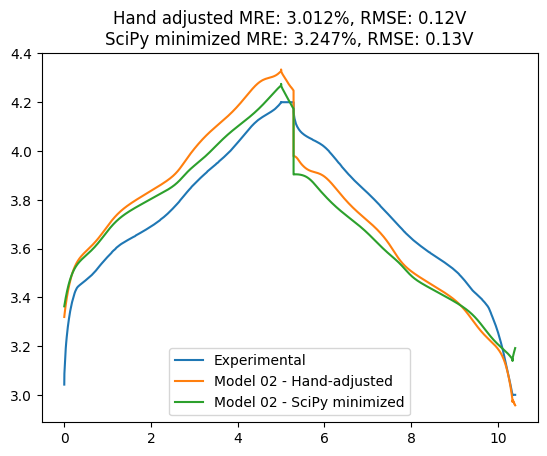

In [4]:
# Refine parameters using SciPy minimize.
from scipy.optimize import minimize

# It only makes sense to refine radiuses (thus total capacity) and initial concentrations.
def loss(x):
    p = ParameterSet()
    p.r_n, p.r_p, p.c_init_n, p.c_init_p = x
    m = Model(p, c)
    t, U = m.solve(t_eval=exp_t)
    return root_mean_square_error(U, exp_u)

x0 = [0.02009/2, 0.01778/2, 1000, 49000]
res = minimize(loss, x0)

p = ParameterSet()

# Experimental reference
plt.plot(exp_t/3600, exp_u, label="Experimental")

# Plot model with hand-adjusted parameters
x0_hand = [0.02009/2*1, 0.01778/2*1.05, 750, 48000]
p.r_n, p.r_p, p.c_init_n, p.c_init_p = x0_hand
m = Model(p, c)
t, U = m.solve(t_eval=exp_t)
plt.plot(t/3600, U, label="Model 02 - Hand-adjusted")

# Plot model with SciPy minimize adjusted parameters
p.r_n, p.r_p, p.c_init_n, p.c_init_p = res.x
m = Model(p, c)
t_res, U_res = m.solve(t_eval=exp_t)
plt.plot(t_res/3600, U_res, label="Model 02 - SciPy minimized")

plt.title(f"Hand adjusted MRE: {mean_relative_error(U, exp_u):.3%}, RMSE: {root_mean_square_error(U, exp_u):.2f}V\nSciPy minimized MRE: {mean_relative_error(U_res, exp_u):.3%}, RMSE: {root_mean_square_error(U_res, exp_u):.2f}V")
plt.legend()


# Conclusion
The model is quite nice already. 

Choosing particle size parameters and inital concentration parameters by hand yields a nice curve, where the obvious discrepancy is the lack of modeling overpotential. 

The SciPy minimization on the other hand yields a very unphysical fit, and cannot be trusted to provide accurate parameters.